In [3]:
import torch
from torch import nn
from torch.functional import F

if torch.cuda.is_available():
    device = "cuda:0"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
device

'cuda:0'

In [4]:
from pathlib import Path

data_path = Path("datasets")
image_path = data_path / "agan"

In [5]:
import os

def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [6]:
walk_through_dir(image_path)

There are 3 directories and 1 images in 'datasets/agan'.
There are 2 directories and 1 images in 'datasets/agan/train'.
There are 0 directories and 861 images in 'datasets/agan/train/gt'.
There are 1 directories and 861 images in 'datasets/agan/train/data'.
There are 0 directories and 1 images in 'datasets/agan/train/data/.ipynb_checkpoints'.
There are 2 directories and 1 images in 'datasets/agan/test_a'.
There are 0 directories and 58 images in 'datasets/agan/test_a/gt'.
There are 0 directories and 58 images in 'datasets/agan/test_a/data'.
There are 2 directories and 1 images in 'datasets/agan/test_b'.
There are 0 directories and 249 images in 'datasets/agan/test_b/gt'.
There are 0 directories and 249 images in 'datasets/agan/test_b/data'.


In [7]:
train_dir = image_path / "train"
test_dir = image_path / "test_a"

train_dir, test_dir

(PosixPath('datasets/agan/train'), PosixPath('datasets/agan/test_a'))

Random data image path: datasets/agan/train/data/68_rain.png
Image height: 480 	 Image width: 720

Random clean image path: datasets/agan/train/gt/68_clean.png
Image height: 480 	 Image width: 720


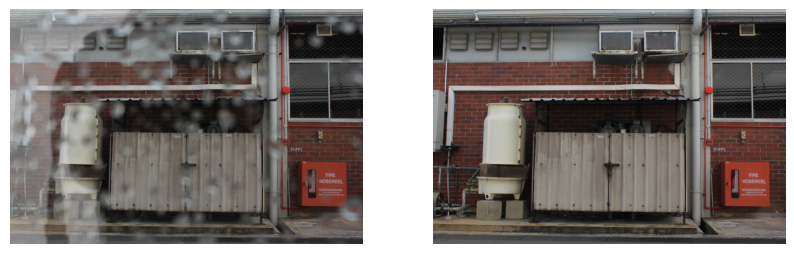

In [8]:
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

random.seed(42)

data_image_path_list = sorted(list(train_dir.glob("data/*.png")))
clean_image_path_list = sorted(list(train_dir.glob("gt/*.png")))

rand_idx = random.randint(0,len(data_image_path_list))

data_img = np.asarray(Image.open(data_image_path_list[rand_idx]))
clean_img = np.asarray(Image.open(clean_image_path_list[rand_idx]))

plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.imshow(data_img)
plt.axis(False)
plt.subplot(1,2,2)
plt.imshow(clean_img)
plt.axis(False)

print(f"Random data image path: {data_image_path_list[rand_idx]}")
print(f"Image height: {data_img.shape[0]} \t Image width: {data_img.shape[1]}")

print(f"\nRandom clean image path: {clean_image_path_list[rand_idx]}")
print(f"Image height: {clean_img.shape[0]} \t Image width: {clean_img.shape[1]}")

In [44]:
from torch.utils.data import DataLoader
from torchvision import transforms

data_transform = transforms.Compose([
    transforms.CenterCrop(size=(480, 480)),
    transforms.RandomHorizontalFlip(),
    transforms.transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                        std=[0.5, 0.5, 0.5])
])

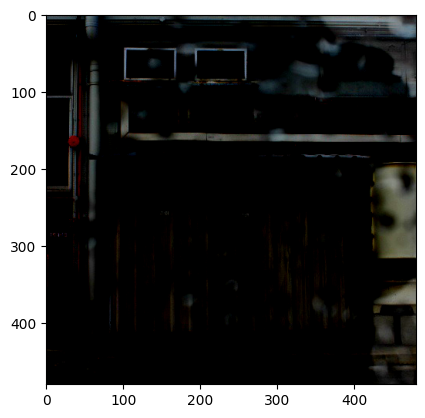

In [47]:
plt.imshow(data_transform(Image.open(data_image_path_list[rand_idx])).permute(1,2,0).clip(0,255).detach().cpu().numpy())

In [50]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    idxs = random.sample(range(0, len(image_paths)), k=n)
    for idx in idxs:
        f = Image.open(image_paths[idx])

        fig, ax = plt.subplots(1, 2, figsize=(10,10))
        ax[0].imshow(f)
        ax[0].set_title(f"Original \nSize: {f.size}")
        ax[0].axis("off")

        transformed_data_img = transform(f).permute(1,2,0).clip(0,255)
        ax[1].imshow(transformed_data_img)
        ax[1].set_title(f"Transformed\nSize: {transformed_data_img.shape}")
        ax[1].axis("off")

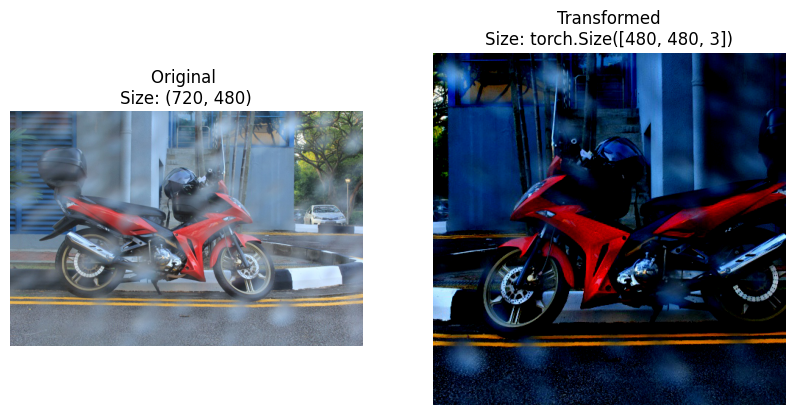

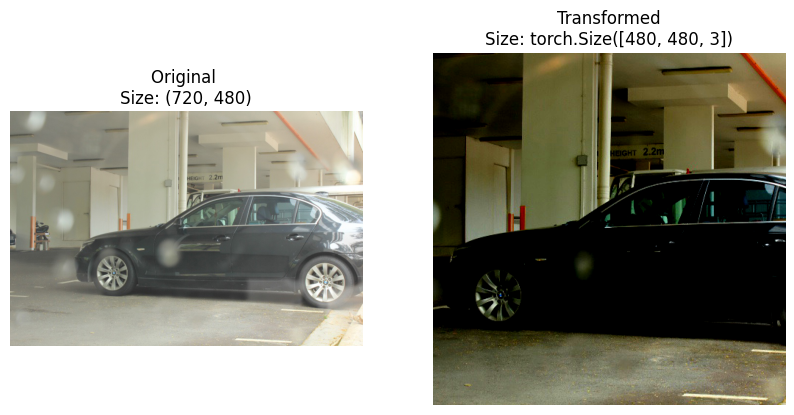

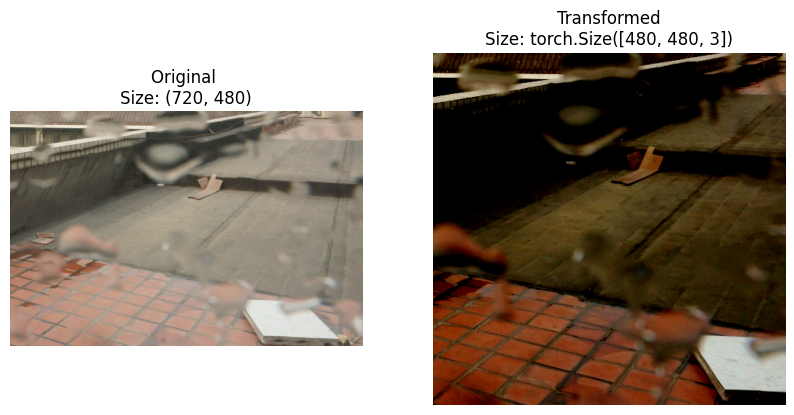

In [51]:
plot_transformed_images(data_image_path_list, data_transform)

In [52]:
from torch.utils.data import Dataset
import pathlib
from typing import Tuple

class RainDataset(Dataset):
    def __init__(self, targ_dir: str, transform=None, seed=42) -> None:
        # Get all iamge paths
        self.data_paths = sorted(list(pathlib.Path(targ_dir).glob("data/*.png")))
        self.gt_paths = sorted(list(pathlib.Path(targ_dir).glob("gt/*.png")))
        self.seed = seed

        # Setup transforms
        self.transform = transform

    def load_image(self, index: int) -> Image.Image:
        data_path, gt_path = self.data_paths[index], self.gt_paths[index]
        return Image.open(data_path).convert("RGB"), Image.open(gt_path).convert("RGB")

    # to check length for a paired dataset
    def get_length(self) -> Tuple[int, int]:
        return len(self.data_paths), len(self.gt_paths)
        
    # optional to override this but recommended
    def __len__(self) -> int: 
        return min(len(self.data_paths), len(self.gt_paths))
        
    # must override
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        data_img, gt_img = self.load_image(index)

        if self.transform:
            torch.manual_seed(self.seed)
            data_img = self.transform(data_img)
            torch.manual_seed(self.seed)
            gt_img = self.transform(gt_img)
        
        return data_img, gt_img

In [53]:
train_transform = transforms.Compose([
    transforms.CenterCrop(size=(480, 480)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                        std=[0.5, 0.5, 0.5])
])

test_transform = transforms.Compose([
    transforms.CenterCrop(size=(480, 480)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                        std=[0.5, 0.5, 0.5])
])

train_data_custom = RainDataset(targ_dir = "./datasets/agan/train/", 
                                transform = train_transform)
test_data_custom = RainDataset(targ_dir = "./datasets/agan/test_a/",
                               transform = test_transform)
train_data_custom, test_data_custom

(<__main__.RainDataset at 0x7414b83581c0>,
 <__main__.RainDataset at 0x7414b83586d0>)

In [54]:
len(train_data_custom), len(test_data_custom)

(861, 58)

In [55]:
train_len, test_len = train_data_custom.get_length(), test_data_custom.get_length()
print(f"Train dataset samples: {train_len}\n Test dataset samples: {test_len}")

Train dataset samples: (861, 861)
 Test dataset samples: (58, 58)


In [56]:
from torch.utils.data import DataLoader

train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=64,
                                     shuffle=True)
test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=16,
                                    shuffle=False)
train_data_custom, test_dataloader_custom

(<__main__.RainDataset at 0x7414b83581c0>,
 <torch.utils.data.dataloader.DataLoader at 0x7414b835add0>)

In [57]:
data, gt = next(iter(train_dataloader_custom))
data.shape, gt.shape

(torch.Size([64, 3, 480, 480]), torch.Size([64, 3, 480, 480]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9137255..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


(np.float64(-0.5), np.float64(479.5), np.float64(479.5), np.float64(-0.5))

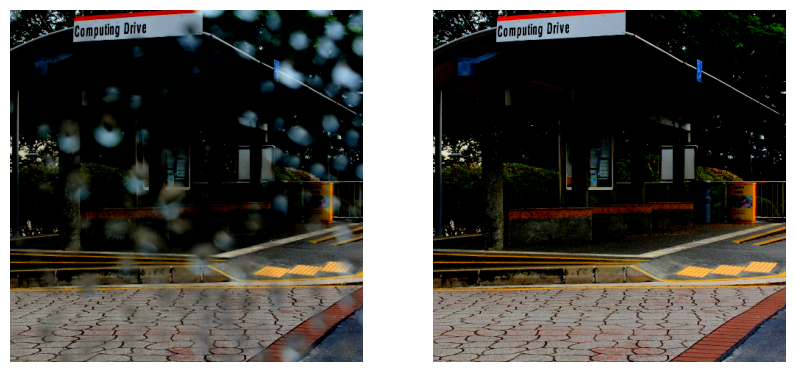

In [58]:
plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.imshow(data[3,:,:,:].squeeze().permute(1,2,0).detach().cpu().numpy())
plt.axis(False)
plt.subplot(1,2,2)
plt.imshow(gt[3,:,:,:].squeeze().permute(1,2,0).detach().cpu().numpy())
plt.axis(False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.7019608].


(np.float64(-0.5), np.float64(479.5), np.float64(479.5), np.float64(-0.5))

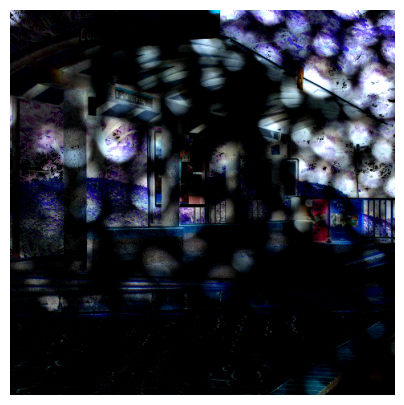

In [60]:
plt.figure(figsize=(5,5))
plt.imshow(torch.clamp((data[3,:,:,:]-gt[3,:,:,:]), 0,255).squeeze().permute(1,2,0).detach().cpu().numpy())
plt.axis(False)